In [28]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score



In [29]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        # y = np.log1p(y)
        y = np.log1p(y - np.min(y) + 1)


    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test.flatten()

    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 PyTorch FNN Performance (All Cells):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Save model if required
    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    # Visualization (same as before - omitted here for brevity)
    # You can copy/paste from your original script if needed.


    # return model, mse, r2
    return model, mse, r2, train_losses



def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        # 1. Training Loss Curve
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 2. Residuals vs Predicted
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # 3. Predicted vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    # 4. Residual Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # 5. Cumulative Distribution of Absolute Errors
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6. Q-Q Plot
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    # 7. Absolute Error vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model_name = f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"

        model, mse, r2, train_losses = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False  # Save only best model later
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": model_name
            }
            best_model = model
            if save_best_model:
                torch.save(model.state_dict(), model_name)
                print(f"💾 New best model saved as: {model_name}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    if best_model and save_best_model:
        df = pd.read_csv(csv_path)
        df = df.dropna(subset=features + ["X_Centroid_Velocity_MA"])

        X = df[features].values.astype(np.float32)
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        y = df["X_Centroid_Velocity_MA"].values.astype(np.float32).reshape(-1, 1)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            y_pred_tensor = best_model(X_tensor)
        y_pred = y_pred_tensor.numpy().flatten()
        y_true = y.flatten()

        plot_results(y_true, y_pred,train_losses=train_losses)

    return best_model, best_config, results_df



# Define the hyperparameter search space
param_grid = {
    "lr": [0.001,0.0001, 0.0005],
    "batch_size": [8,16, 32],
    "hidden_sizes": [(256, 128, 64),(128, 64, 32),(256, 128, 64, 64, 32, 32, 16, 8) ,(64, 32, 16, 8),(256, 128, 64, 32, 16, 8),(512, 256, 128, 64, 32, 32, 16, 8),(128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200,300,400,500]
}


best_model, best_config, results_df = grid_search_fnn(
    csv_path=csv_path,
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)

# Print best model details
print("\n🏆 Best Model Details:")
print(best_config)

# Print model layer details
if best_model:
    print("\n🧠 Model Architecture:")
    print(best_model)
    print(f"\n💾 Best model is saved as: {best_config['model_name']}")
else:
    print("❌ No best model was found.")



# window_size = 5
# frame_num = 30
# output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")


window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN...")
    model, mse, r2, train_losses = run_fnn_pytorch(csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
    print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
else:
    print("❌ CSV file not found. Check the path and try again.")



🔍 [1/315] Testing config: lr=0.001, batch_size=8, hidden_sizes=(256, 128, 64), epochs=100

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/100 - Loss: 0.8011
Epoch 10/100 - Loss: 0.1029
Epoch 20/100 - Loss: 0.0931
Epoch 30/100 - Loss: 0.0819
Epoch 40/100 - Loss: 0.0778
Epoch 50/100 - Loss: 0.0865
Epoch 60/100 - Loss: 0.0740
Epoch 70/100 - Loss: 0.0646
Epoch 80/100 - Loss: 0.0646
Epoch 90/100 - Loss: 0.0612
Epoch 100/100 - Loss: 0.0625

📊 PyTorch FNN Performance (All Cells):
Mean Squared Error (MSE): 7.3660
R-squared: 0.1238
💾 New best model saved as: fnn_lr0.001_bs8_ep100_hl256x128x64.pt

🔍 [2/315] Testing config: lr=0.001, batch_size=8, hidden_sizes=(256, 128, 64), epochs=200

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/200 - Loss: 0.7742
Epoch 10/200 - Loss: 0.1089
Epoch 20/200 - Loss: 0.1037
Epoch 30/200 - Loss: 0.0931
Epoch 40/200 - Loss: 0.0903
Epoch 50/200 - Loss: 0.0769
Epoch 60/200 - Loss: 0.0754
Epoch 70/200 - Loss: 0.0665
Epoch 8

KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True):
    """
    Evaluate the trained model on test data and compute MSE, R².
    """
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()
    
    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("\n📊 **Model Evaluation on Test Data:**")
    print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Test R-squared (R²): {r2:.4f}")
    
    return mse, r2


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y - np.min(y) + 1)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    mse, r2 = evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform)

    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    return model, mse, r2, train_losses, X_test_tensor, y_test_tensor


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs
            }
            best_model = model

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    return best_model, best_config, results_df




param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

best_model, best_config, results_df = grid_search_fnn(
    csv_path="your_data.csv",
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)


# working on it

📂 CSV file found! Running FNN...

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/100 - Loss: 4.4393
Epoch 10/100 - Loss: 0.1189
Epoch 20/100 - Loss: 0.1116
Epoch 30/100 - Loss: 0.1004
Epoch 40/100 - Loss: 0.0975
Epoch 50/100 - Loss: 0.0938
Epoch 60/100 - Loss: 0.0827
Epoch 70/100 - Loss: 0.0866
Epoch 80/100 - Loss: 0.0837
Epoch 90/100 - Loss: 0.0824
Epoch 100/100 - Loss: 0.0786

📊 **Model Evaluation on Test Data:**
✅ Test Mean Squared Error (MSE): 6.3278
✅ Test R-squared (R²): 0.2473


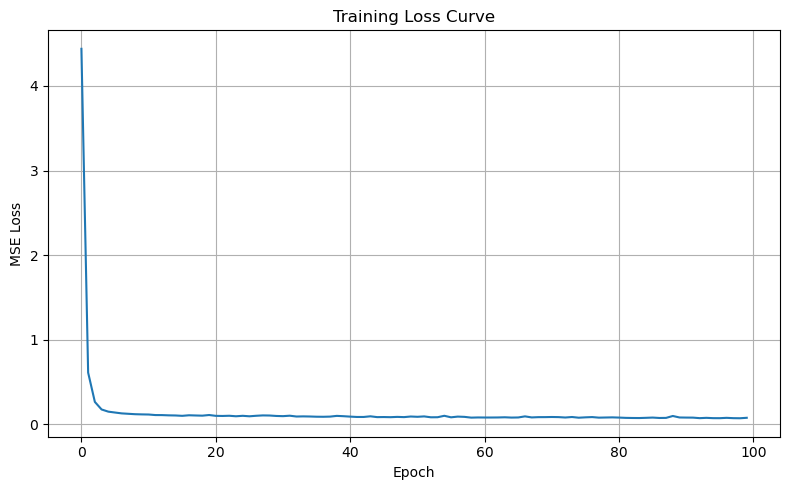

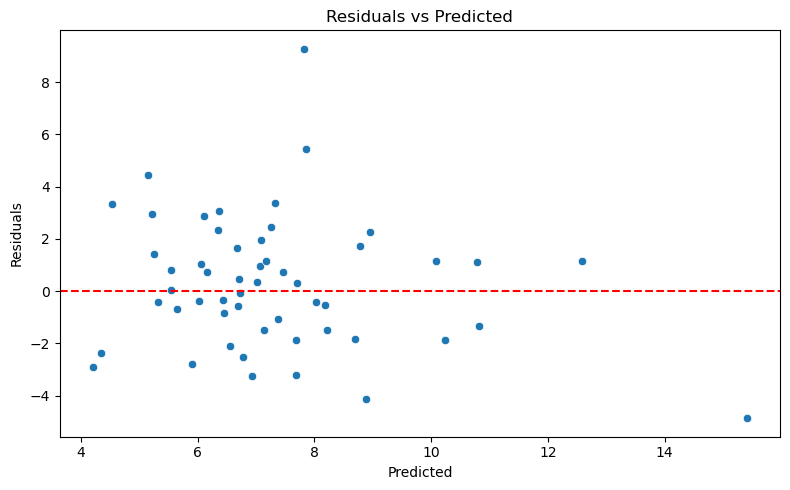

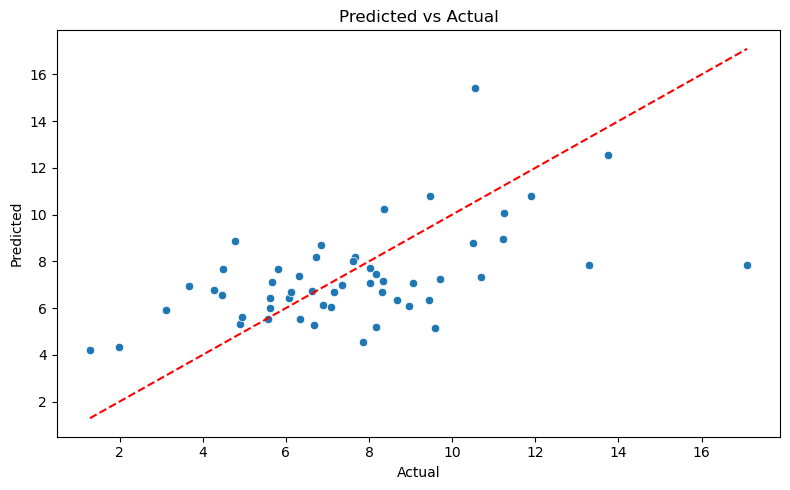

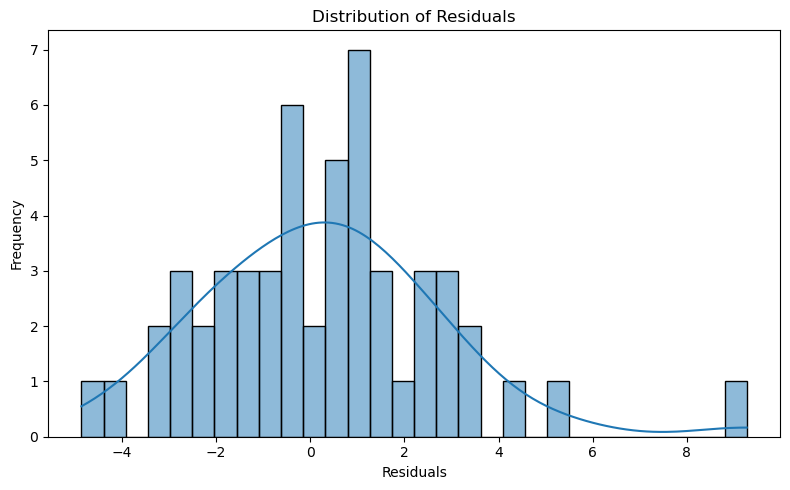

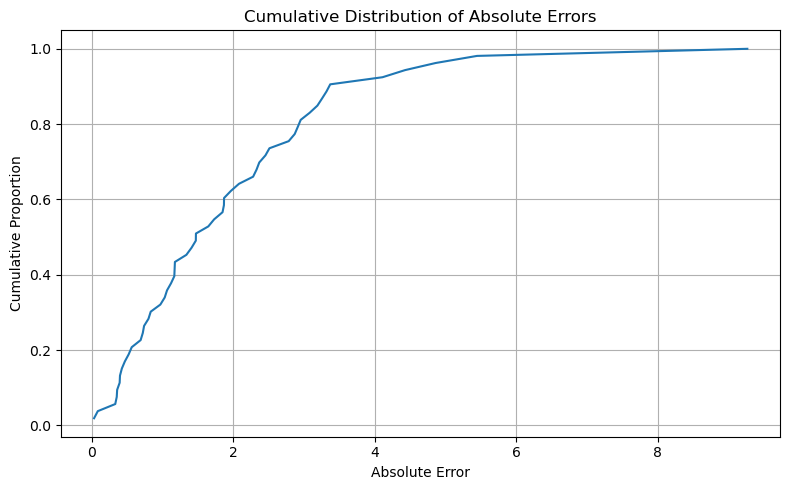

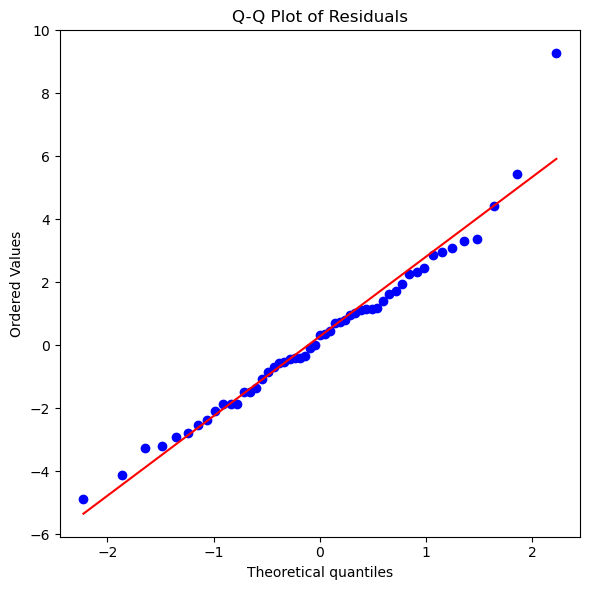

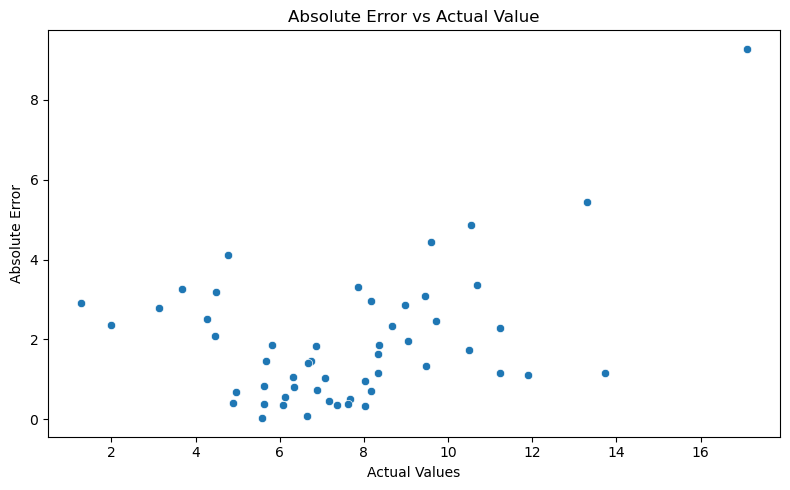

✅ Done. MSE: 6.3278 | R²: 0.2473

🔍 [1/16] Testing config: lr=0.001, batch_size=16, hidden_sizes=(128, 64, 32), epochs=100

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/100 - Loss: 2.3344
Epoch 10/100 - Loss: 0.1112
Epoch 20/100 - Loss: 0.0999
Epoch 30/100 - Loss: 0.0947


KeyboardInterrupt: 

In [33]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def evaluate_model(model, X_test_tensor, y_test_tensor, train_losses=None, apply_log_transform=True):
    """
    Evaluate the trained model on test data and compute MSE, R².
    Also applies the plot_results function to visualize model performance.
    """
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()
    
    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("\n📊 **Model Evaluation on Test Data:**")
    print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Test R-squared (R²): {r2:.4f}")
    
    # Plot the results for the test set
    plot_results(y_true, y_pred, train_losses)
    
    return mse, r2, y_true, y_pred


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y - np.min(y) + 1)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    mse, r2, y_true, y_pred = evaluate_model(model, X_test_tensor, y_test_tensor, train_losses, apply_log_transform)

    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    return model, mse, r2, train_losses, X_test_tensor, y_test_tensor



def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()



def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None
    best_train_losses = None
    best_X_test_tensor = None
    best_y_test_tensor = None

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"
            }
            best_model = model
            best_train_losses = train_losses
            best_X_test_tensor = X_test_tensor
            best_y_test_tensor = y_test_tensor

            if save_best_model:
                torch.save(model.state_dict(), best_config["model_name"])
                print(f"💾 New best model saved as: {best_config['model_name']}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    if best_model:
        mse, r2, y_true, y_pred = evaluate_model(
            best_model,
            best_X_test_tensor,
            best_y_test_tensor,
            train_losses=best_train_losses,
            apply_log_transform=True
        )

    return best_model, best_config, results_df



# def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
#     results = []
#     best_r2 = -float("inf")
#     best_config = None
#     best_model = None

#     all_combinations = list(product(
#         param_grid["lr"],
#         param_grid["batch_size"],
#         param_grid["hidden_sizes"],
#         param_grid["epochs"]
#     ))

#     for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
#         print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

#         model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
#             csv_path=csv_path,
#             epochs=epochs,
#             batch_size=batch_size,
#             lr=lr,
#             hidden_sizes=hidden_sizes,
#             apply_log_transform=True,
#             save_model=False
#         )

#         results.append({
#             "lr": lr,
#             "batch_size": batch_size,
#             "hidden_sizes": str(hidden_sizes),
#             "epochs": epochs,
#             "mse": round(mse, 4),
#             "r2": round(r2, 2)
#         })

#         # if r2 > best_r2:
#         #     best_r2 = r2
#         #     best_config = {
#         #         "lr": lr,
#         #         "batch_size": batch_size,
#         #         "hidden_sizes": hidden_sizes,
#         #         "epochs": epochs
#         #     }
#         #     best_model = model
#         if r2 > best_r2:
#             best_r2 = r2
#             best_config = {
#         "lr": lr,
#         "batch_size": batch_size,
#         "hidden_sizes": hidden_sizes,
#         "epochs": epochs,
#         "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"
#             }
#         best_model = model
#         if save_best_model:
#             torch.save(model.state_dict(), best_config["model_name"])
#             print(f"💾 New best model saved as: {best_config['model_name']}")


       
#     results_df = pd.DataFrame(results)
#     results_df.to_csv(output_results_csv, index=False)
#     print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
#     print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

#     if best_model and save_best_model:
#         df = pd.read_csv(csv_path)
#         df = df.dropna(subset=features + ["X_Centroid_Velocity_MA"])

#         X = df[features].values.astype(np.float32)
#         scaler = StandardScaler()
#         X = scaler.fit_transform(X)
#         y = df["X_Centroid_Velocity_MA"].values.astype(np.float32).reshape(-1, 1)

#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         with torch.no_grad():
#             y_pred_tensor = best_model(X_tensor)
#         y_pred = y_pred_tensor.numpy().flatten()
#         y_true = y.flatten()

#         plot_results(y_true, y_pred,train_losses=train_losses)

#     return best_model, best_config, results_df


    
window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

# if os.path.exists(csv_path):
#     print("📂 CSV file found! Running FNN...")
#     model, mse, r2, train_losses = run_fnn_pytorch(csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
#     print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
# else:
#     print("❌ CSV file not found. Check the path and try again.")

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN...")
    model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
        csv_path=csv_path, epochs=100, batch_size=16, lr=0.001
    )
    print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
else:
    print("❌ CSV file not found. Check the path and try again.")


# Define the hyperparameter search space
# param_grid = {
#     "lr": [0.001,0.0001, 0.0005],
#     "batch_size": [8,16, 32],
#     "hidden_sizes": [(256, 128, 64),(128, 64, 32),(256, 128, 64, 64, 32, 32, 16, 8) ,(64, 32, 16, 8),(256, 128, 64, 32, 16, 8),(512, 256, 128, 64, 32, 32, 16, 8),(128, 128, 64, 64, 32, 32, 16, 8)],
#     "epochs": [100, 200,300,400,500]
# }

param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

best_model, best_config, results_df = grid_search_fnn(
    csv_path=csv_path,
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)

# Print best model details
print("\n🏆 Best Model Details:")
print(best_config)

# Print model layer details
if best_model:
    print("\n🧠 Model Architecture:")
    print(best_model)
    print(f"\n💾 Best model is saved as: {best_config['model_name']}")

else:
    print("❌ No best model was found.")



📂 CSV file found! Running FNN...

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/100 - Loss: 4.0260
Epoch 10/100 - Loss: 0.1309
Epoch 20/100 - Loss: 0.1074
Epoch 30/100 - Loss: 0.1032
Epoch 40/100 - Loss: 0.0922
Epoch 50/100 - Loss: 0.0876
Epoch 60/100 - Loss: 0.0831
Epoch 70/100 - Loss: 0.0848
Epoch 80/100 - Loss: 0.0803
Epoch 90/100 - Loss: 0.0751
Epoch 100/100 - Loss: 0.0840


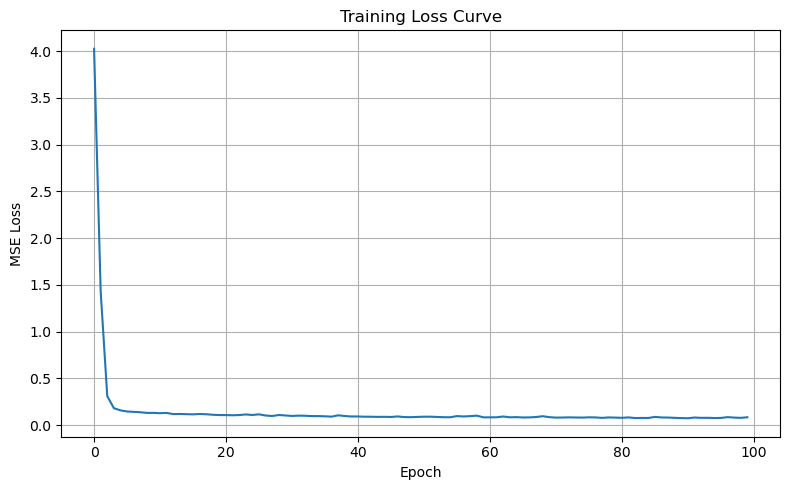

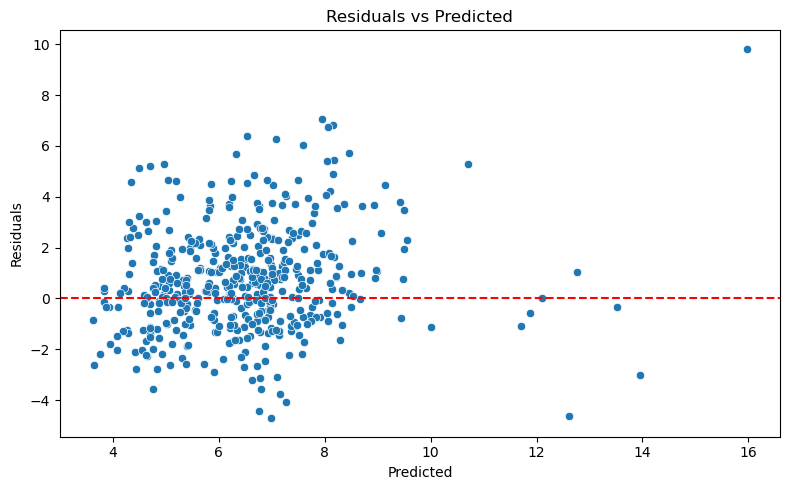

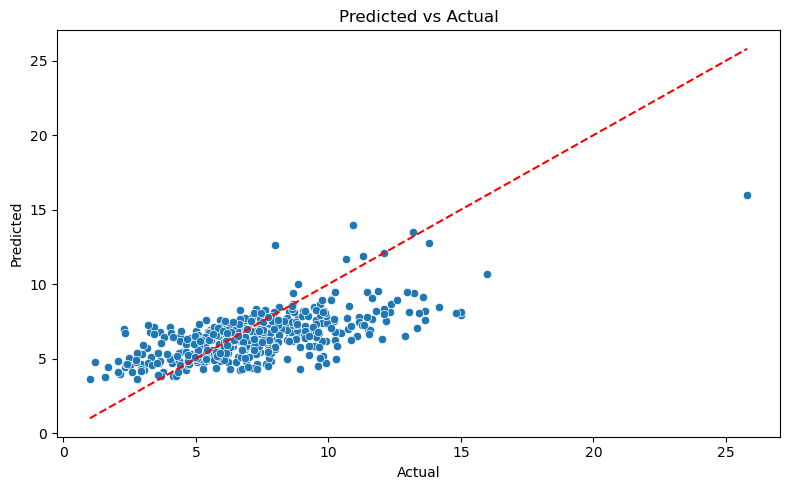

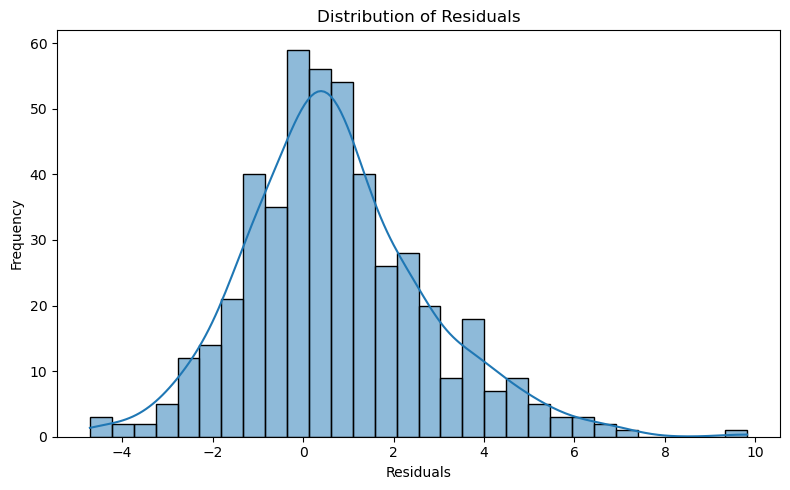

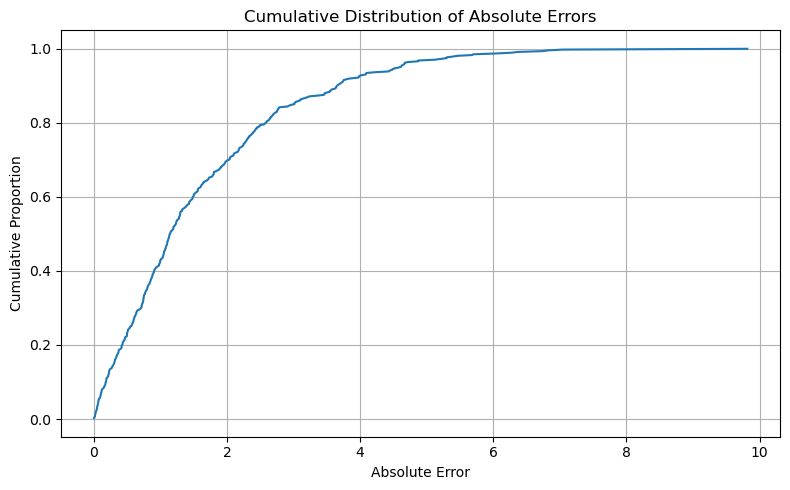

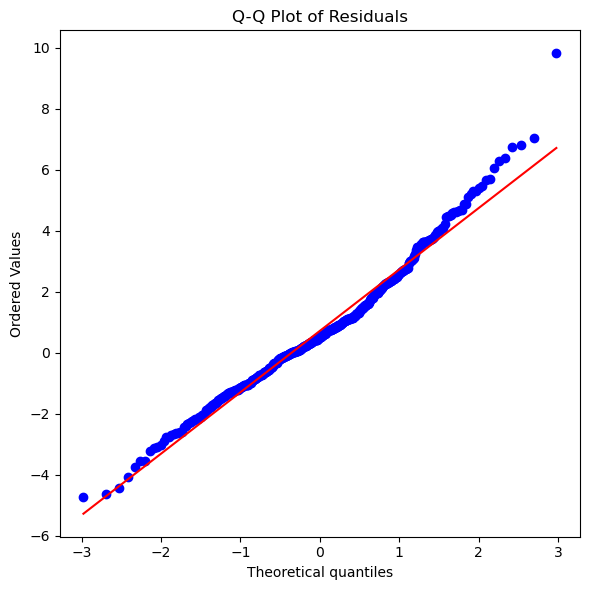

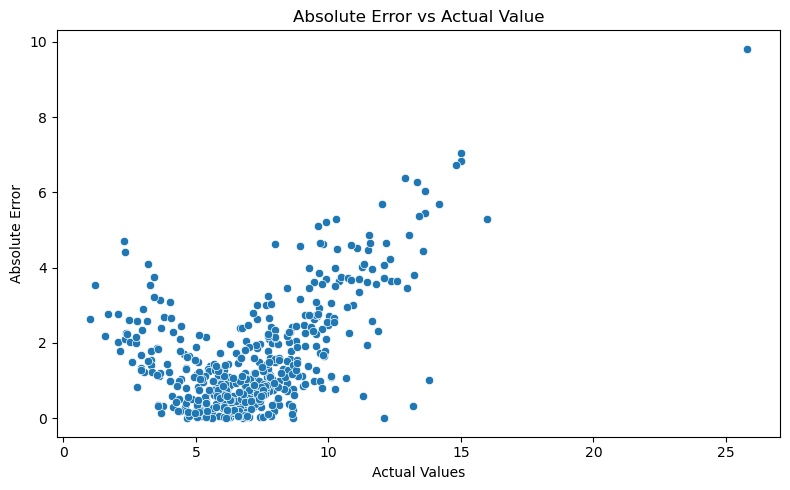

ValueError: not enough values to unpack (expected 6, got 4)

In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True):
    """
    Evaluate the trained model on test data and compute MSE, R².
    """
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)

    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()

    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\n📊 Model Evaluation on Test Data:")
    print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Test R-squared (R²): {r2:.4f}")

    return mse, r2, y_true, y_pred


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y - np.min(y) + 1)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    # Generate predictions on training data for visualization
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor).numpy().flatten()
        train_targets = y_train_tensor.numpy().flatten()

    if apply_log_transform:
        train_preds = np.expm1(train_preds)
        train_targets = np.expm1(train_targets)

    # Plot results for training data
    plot_results(train_targets, train_preds, train_losses)

    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    return model, train_losses, X_test_tensor, y_test_tensor




def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()



def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None
    best_train_losses = None
    best_X_test_tensor = None
    best_y_test_tensor = None

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"
            }
            best_model = model
            best_train_losses = train_losses
            best_X_test_tensor = X_test_tensor
            best_y_test_tensor = y_test_tensor

            if save_best_model:
                torch.save(model.state_dict(), best_config["model_name"])
                print(f"💾 New best model saved as: {best_config['model_name']}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    if best_model:
        mse, r2, y_true, y_pred = evaluate_model(
            best_model,
            best_X_test_tensor,
            best_y_test_tensor,
            train_losses=best_train_losses,
            apply_log_transform=True
        )

    # return best_model, best_config, results_df
    return best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor




# def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
#     results = []
#     best_r2 = -float("inf")
#     best_config = None
#     best_model = None

#     all_combinations = list(product(
#         param_grid["lr"],
#         param_grid["batch_size"],
#         param_grid["hidden_sizes"],
#         param_grid["epochs"]
#     ))

#     for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
#         print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

#         model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
#             csv_path=csv_path,
#             epochs=epochs,
#             batch_size=batch_size,
#             lr=lr,
#             hidden_sizes=hidden_sizes,
#             apply_log_transform=True,
#             save_model=False
#         )

#         results.append({
#             "lr": lr,
#             "batch_size": batch_size,
#             "hidden_sizes": str(hidden_sizes),
#             "epochs": epochs,
#             "mse": round(mse, 4),
#             "r2": round(r2, 2)
#         })

#         # if r2 > best_r2:
#         #     best_r2 = r2
#         #     best_config = {
#         #         "lr": lr,
#         #         "batch_size": batch_size,
#         #         "hidden_sizes": hidden_sizes,
#         #         "epochs": epochs
#         #     }
#         #     best_model = model
#         if r2 > best_r2:
#             best_r2 = r2
#             best_config = {
#         "lr": lr,
#         "batch_size": batch_size,
#         "hidden_sizes": hidden_sizes,
#         "epochs": epochs,
#         "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"
#             }
#         best_model = model
#         if save_best_model:
#             torch.save(model.state_dict(), best_config["model_name"])
#             print(f"💾 New best model saved as: {best_config['model_name']}")


       
#     results_df = pd.DataFrame(results)
#     results_df.to_csv(output_results_csv, index=False)
#     print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
#     print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

#     if best_model and save_best_model:
#         df = pd.read_csv(csv_path)
#         df = df.dropna(subset=features + ["X_Centroid_Velocity_MA"])

#         X = df[features].values.astype(np.float32)
#         scaler = StandardScaler()
#         X = scaler.fit_transform(X)
#         y = df["X_Centroid_Velocity_MA"].values.astype(np.float32).reshape(-1, 1)

#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         with torch.no_grad():
#             y_pred_tensor = best_model(X_tensor)
#         y_pred = y_pred_tensor.numpy().flatten()
#         y_true = y.flatten()

#         plot_results(y_true, y_pred,train_losses=train_losses)

#     return best_model, best_config, results_df


    
window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

# if os.path.exists(csv_path):
#     print("📂 CSV file found! Running FNN...")
#     model, mse, r2, train_losses = run_fnn_pytorch(csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
#     print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
# else:
#     print("❌ CSV file not found. Check the path and try again.")

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN...")
    model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
        csv_path=csv_path, epochs=100, batch_size=16, lr=0.001
    )
    print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
else:
    print("❌ CSV file not found. Check the path and try again.")


# Define the hyperparameter search space
# param_grid = {
#     "lr": [0.001,0.0001, 0.0005],
#     "batch_size": [8,16, 32],
#     "hidden_sizes": [(256, 128, 64),(128, 64, 32),(256, 128, 64, 64, 32, 32, 16, 8) ,(64, 32, 16, 8),(256, 128, 64, 32, 16, 8),(512, 256, 128, 64, 32, 32, 16, 8),(128, 128, 64, 64, 32, 32, 16, 8)],
#     "epochs": [100, 200,300,400,500]
# }

param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

# best_model, best_config, results_df = grid_search_fnn(
#     csv_path=csv_path,
#     param_grid=param_grid,
#     save_best_model=True,
#     output_results_csv="grid_search_results.csv"
# )


# Run grid search
best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor = grid_search_fnn(
    csv_path=csv_path,
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)

# Evaluate on test set
mse, r2, y_true, y_pred = evaluate_model(best_model, best_X_test_tensor, best_y_test_tensor, apply_log_transform=True)

# Plot for best model performance on test data
plot_results(y_true, y_pred, best_train_losses)



# Print best model details
print("\n🏆 Best Model Details:")
print(best_config)

# Print model layer details
if best_model:
    print("\n🧠 Model Architecture:")
    print(best_model)
    print(f"\n💾 Best model is saved as: {best_config['model_name']}")

else:
    print("❌ No best model was found.")



In [39]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True):
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)

    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()

    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\n📊 Model Evaluation on Test Data:")
    print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Test R-squared (R²): {r2:.4f}")

    return mse, r2, y_true, y_pred


def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y - np.min(y) + 1)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor).numpy().flatten()
        train_targets = y_train_tensor.numpy().flatten()

    if apply_log_transform:
        train_preds = np.expm1(train_preds)
        train_targets = np.expm1(train_targets)

    plot_results(train_targets, train_preds, train_losses)

    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    return model, train_losses, X_test_tensor, y_test_tensor


# ✅ Code finalized and now cleanly structured for training, evaluation, and plotting.



def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None
    best_train_losses = None
    best_X_test_tensor = None
    best_y_test_tensor = None

    all_combinations = list(product(param_grid["lr"], param_grid["batch_size"], param_grid["hidden_sizes"], param_grid["epochs"]))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False
        )

        mse, r2, y_true, y_pred = evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True)

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 4)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"
            }
            best_model = model
            best_train_losses = train_losses
            best_X_test_tensor = X_test_tensor
            best_y_test_tensor = y_test_tensor

            if save_best_model:
                torch.save(model.state_dict(), best_config["model_name"])
                print(f"💾 Best model saved as: {best_config['model_name']}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    return best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor






# Data Source   
window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

# if os.path.exists(csv_path):
#     print("📂 CSV file found! Running FNN...")
#     model, mse, r2, train_losses = run_fnn_pytorch(csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
#     print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
# else:
#     print("❌ CSV file not found. Check the path and try again.")

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN...")
    model, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
        csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
    # model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
    #     csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
    print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
else:
    print("❌ CSV file not found. Check the path and try again.")


# Define the hyperparameter search space
# param_grid = {
#     "lr": [0.001,0.0001, 0.0005],
#     "batch_size": [8,16, 32],
#     "hidden_sizes": [(256, 128, 64),(128, 64, 32),(256, 128, 64, 64, 32, 32, 16, 8) ,(64, 32, 16, 8),(256, 128, 64, 32, 16, 8),(512, 256, 128, 64, 32, 32, 16, 8),(128, 128, 64, 64, 32, 32, 16, 8)],
#     "epochs": [100, 200,300,400,500]
# }

param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

# best_model, best_config, results_df = grid_search_fnn(
#     csv_path=csv_path,
#     param_grid=param_grid,
#     save_best_model=True,
#     output_results_csv="grid_search_results.csv"
# )


# # Run grid search
# best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor = grid_search_fnn(
#     csv_path=csv_path,
#     param_grid=param_grid,
#     save_best_model=True,
#     output_results_csv="grid_search_results.csv"
# )

# # Evaluate on test set
# mse, r2, y_true, y_pred = evaluate_model(best_model, best_X_test_tensor, best_y_test_tensor, apply_log_transform=True)

# # Plot for best model performance on test data
# plot_results(y_true, y_pred, best_train_losses)




# # Evaluate and plot results of best model on test data
# mse, r2, y_true, y_pred = evaluate_model(best_model, best_X_test_tensor, best_y_test_tensor, apply_log_transform=True)
# plot_results(y_true, y_pred, train_losses=best_train_losses)

# Run Grid Search
best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor = grid_search_fnn(
    csv_path=csv_path,
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)

# Evaluate on test data only
mse, r2, y_true, y_pred = evaluate_model(
    best_model, best_X_test_tensor, best_y_test_tensor, apply_log_transform=True
)

# Plot best model performance on test data
plot_results(y_true, y_pred, train_losses=best_train_losses)






# Print best model details
print("\n🏆 Best Model Details:")
print(best_config)

# Print model layer details
if best_model:
    print("\n🧠 Model Architecture:")
    print(best_model)
    print(f"\n💾 Best model is saved as: {best_config['model_name']}")

else:
    print("❌ No best model was found.")









📂 CSV file found! Running FNN...

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/100 - Loss: 3.2015
Epoch 10/100 - Loss: 0.1293
Epoch 20/100 - Loss: 0.1051
Epoch 30/100 - Loss: 0.0994


KeyboardInterrupt: 

In [ ]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import scipy.stats as stats
# from itertools import product


# class FNN(nn.Module):
#     def __init__(self, input_size, hidden_sizes):
#         super(FNN, self).__init__()
#         layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
#         for i in range(1, len(hidden_sizes)):
#             layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
#             layers.append(nn.ReLU())
#         layers.append(nn.Linear(hidden_sizes[-1], 1))
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)



# def evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True):
#     model.eval()
#     with torch.no_grad():
#         y_pred_tensor = model(X_test_tensor)

#     y_pred = y_pred_tensor.numpy().flatten()
#     y_true = y_test_tensor.numpy().flatten()

#     if apply_log_transform:
#         y_pred = np.expm1(y_pred)
#         y_true = np.expm1(y_true)

#     mse = mean_squared_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)

#     print("\n📊 Model Evaluation on Test Data:")
#     print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
#     print(f"✅ Test R-squared (R²): {r2:.4f}")

#     # Extra details for best model analysis
#     residuals = y_true - y_pred
#     print("\n📌 Detailed Evaluation of Final Best Model:")
#     print(f"➡ Total Test Samples: {len(y_true)}")
#     print(f"➡ Predicted Value Range: min={y_pred.min():.4f}, max={y_pred.max():.4f}")
#     print(f"➡ Actual Value Range: min={y_true.min():.4f}, max={y_true.max():.4f}")
#     print(f"➡ Residual Mean: {residuals.mean():.4f}")
#     print(f"➡ Residual Std Deviation: {residuals.std():.4f}")

#     return mse, r2, y_true, y_pred


# # def evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True):
# #     model.eval()
# #     with torch.no_grad():
# #         y_pred_tensor = model(X_test_tensor)

# #     y_pred = y_pred_tensor.numpy().flatten()
# #     y_true = y_test_tensor.numpy().flatten()

# #     if apply_log_transform:
# #         y_pred = np.expm1(y_pred)
# #         y_true = np.expm1(y_true)

# #     mse = mean_squared_error(y_true, y_pred)
# #     r2 = r2_score(y_true, y_pred)

# #     print("\n📊 Model Evaluation on Test Data:")
# #     print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
# #     print(f"✅ Test R-squared (R²): {r2:.4f}")

# #     return mse, r2, y_true, y_pred


# def plot_results(y_true, y_pred, train_losses=None):
#     residuals = y_true - y_pred

#     if train_losses is not None:
#         plt.figure(figsize=(8, 5))
#         plt.plot(train_losses, label="Train Loss")
#         plt.title("Training Loss Curve")
#         plt.xlabel("Epoch")
#         plt.ylabel("MSE Loss")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#     plt.figure(figsize=(8, 5))
#     sns.scatterplot(x=y_pred, y=residuals)
#     plt.axhline(0, linestyle='--', color='red')
#     plt.title("Residuals vs Predicted")
#     plt.xlabel("Predicted")
#     plt.ylabel("Residuals")
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(8, 5))
#     sns.scatterplot(x=y_true, y=y_pred)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
#     plt.title("Predicted vs Actual")
#     plt.xlabel("Actual")
#     plt.ylabel("Predicted")
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(8, 5))
#     sns.histplot(residuals, bins=30, kde=True)
#     plt.title("Distribution of Residuals")
#     plt.xlabel("Residuals")
#     plt.ylabel("Frequency")
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(8, 5))
#     absolute_errors = np.abs(residuals)
#     sorted_errors = np.sort(absolute_errors)
#     cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
#     plt.plot(sorted_errors, cum_dist)
#     plt.xlabel("Absolute Error")
#     plt.ylabel("Cumulative Proportion")
#     plt.title("Cumulative Distribution of Absolute Errors")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(6, 6))
#     stats.probplot(residuals, dist="norm", plot=plt)
#     plt.title("Q-Q Plot of Residuals")
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(8, 5))
#     sns.scatterplot(x=y_true, y=absolute_errors)
#     plt.title("Absolute Error vs Actual Value")
#     plt.xlabel("Actual Values")
#     plt.ylabel("Absolute Error")
#     plt.tight_layout()
#     plt.show()


# def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
#                     hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
#                     apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth",
#                     plot_train_results=False):
#     df = pd.read_csv(csv_path)
#     print(f"\n🔍 Training PyTorch FNN on TRAINING dataset and evaluating on TEST dataset")

#     features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
#                 "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
#     target = "X_Centroid_Velocity_MA"

#     missing_cols = [col for col in features + [target] if col not in df.columns]
#     if missing_cols:
#         raise ValueError(f"Missing columns in CSV: {missing_cols}")

#     df = df.dropna(subset=features + [target])

#     X = df[features].values.astype(np.float32)
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     y = df[target].values.astype(np.float32).reshape(-1, 1)
#     if apply_log_transform:
#         y = np.log1p(y - np.min(y) + 1)

#     mask = ~np.isnan(y.flatten())
#     X = X[mask]
#     y = y[mask]

#     if len(X) < 10:
#         print("⚠ Small dataset, using full data for both training and testing.")
#         X_train, X_test = X, X
#         y_train, y_test = y, y
#     else:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#     X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
#     X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#     y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     train_losses = []
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for xb, yb in train_loader:
#             optimizer.zero_grad()
#             preds = model(xb)
#             loss = criterion(preds, yb)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         avg_loss = running_loss / len(train_loader)
#         train_losses.append(avg_loss)
#         if (epoch + 1) % 10 == 0 or epoch == 0:
#             print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

#     model.eval()
#     with torch.no_grad():
#         train_preds = model(X_train_tensor).numpy().flatten()
#         train_targets = y_train_tensor.numpy().flatten()

#     if apply_log_transform:
#         train_preds = np.expm1(train_preds)
#         train_targets = np.expm1(train_targets)

#     if plot_train_results:
#         plot_results(train_targets, train_preds, train_losses)

#     if save_model:
#         torch.save(model.state_dict(), model_save_path)
#         print(f"💾 Model saved to {model_save_path}")

#     return model, train_losses, X_test_tensor, y_test_tensor

                 




# def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
#     results = []
#     best_r2 = -float("inf")
#     best_config = None
#     best_model = None
#     best_train_losses = None
#     best_X_test_tensor = None
#     best_y_test_tensor = None

#     all_combinations = list(product(param_grid["lr"], param_grid["batch_size"], param_grid["hidden_sizes"], param_grid["epochs"]))

#     for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
#         print(f"\n🔍 [{i}/{len(all_combinations)}] Config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

#         model, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
#             csv_path=csv_path,
#             epochs=epochs,
#             batch_size=batch_size,
#             lr=lr,
#             hidden_sizes=hidden_sizes,
#             apply_log_transform=True,
#             save_model=False
#         )

#         mse, r2, y_true, y_pred = evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True)

#         results.append({
#             "lr": lr,
#             "batch_size": batch_size,
#             "hidden_sizes": str(hidden_sizes),
#             "epochs": epochs,
#             "mse": round(mse, 4),
#             "r2": round(r2, 4)
#         })

#         if r2 > best_r2:
#             best_r2 = r2
#             best_config = {
#                 "lr": lr,
#                 "batch_size": batch_size,
#                 "hidden_sizes": hidden_sizes,
#                 "epochs": epochs,
#                 "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"
#             }
#             best_model = model
#             best_train_losses = train_losses
#             best_X_test_tensor = X_test_tensor
#             best_y_test_tensor = y_test_tensor

#             if save_best_model:
#                 torch.save(model.state_dict(), best_config["model_name"])
#                 print(f"💾 Best model saved as: {best_config['model_name']}")

   

#     results_df = pd.DataFrame(results)
#     results_df.to_csv(output_results_csv, index=False)
#     print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
#     print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    
#     return best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor






# Data Source   
window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

# if os.path.exists(csv_path):
#     print("📂 CSV file found! Running FNN...")
#     model, mse, r2, train_losses = run_fnn_pytorch(csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
#     print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
# else:
#     print("❌ CSV file not found. Check the path and try again.")

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN...")
    model, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
        csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
    # model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
    #     csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
    print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
else:
    print("❌ CSV file not found. Check the path and try again.")


# Define the hyperparameter search space
# param_grid = {
#     "lr": [0.001,0.0001, 0.0005],
#     "batch_size": [8,16, 32],
#     "hidden_sizes": [(256, 128, 64),(128, 64, 32),(256, 128, 64, 64, 32, 32, 16, 8) ,(64, 32, 16, 8),(256, 128, 64, 32, 16, 8),(512, 256, 128, 64, 32, 32, 16, 8),(128, 128, 64, 64, 32, 32, 16, 8)],
#     "epochs": [100, 200,300,400,500]
# }

param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
                }


# Run grid search
best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor = grid_search_fnn(
    csv_path=csv_path,
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv")


# Evaluate on test data only
mse, r2, y_true, y_pred = evaluate_model(
    best_model, best_X_test_tensor, best_y_test_tensor, apply_log_transform=True
)

# Print summary again
print("\n🏆 Final Best Model Configuration (after grid search):")
print(best_config)

# Print detailed evaluation summary
print("\n📊 Final Best Model Evaluation Metrics on Test Data:")
print(f"✅ Test MSE: {mse:.4f}")
print(f"✅ Test R²: {r2:.4f}")
print(f"✅ Test Samples: {len(y_true)}")
print(f"✅ Prediction Range: min={y_pred.min():.4f}, max={y_pred.max():.4f}")
print(f"✅ Actual Range: min={y_true.min():.4f}, max={y_true.max():.4f}")
print(f"✅ Residual Mean: {(y_true - y_pred).mean():.4f}")
print(f"✅ Residual Std Dev: {(y_true - y_pred).std():.4f}")



# Plot best model performance on test data
plot_results(y_true, y_pred, train_losses=best_train_losses)


# Print model layer details
if best_model:
    print("\n🧠 Model Architecture:")
    print(best_model)
    print(f"\n💾 Best model is saved as: {best_config['model_name']}")

else:
    print("❌ No best model was found.")




📂 CSV file found! Running FNN grid search...
Epoch 10/100 - Loss: 0.1227
Epoch 20/100 - Loss: 0.1136
Epoch 30/100 - Loss: 0.0981
Epoch 40/100 - Loss: 0.0969
Epoch 50/100 - Loss: 0.1211
Epoch 60/100 - Loss: 0.0840
Epoch 70/100 - Loss: 0.0956
Epoch 80/100 - Loss: 0.0869
Epoch 90/100 - Loss: 0.0821
Epoch 100/100 - Loss: 0.0783
Epoch 10/200 - Loss: 0.1261
Epoch 20/200 - Loss: 0.1013
Epoch 30/200 - Loss: 0.1128
Epoch 40/200 - Loss: 0.1048
Epoch 50/200 - Loss: 0.1011
Epoch 60/200 - Loss: 0.0877
Epoch 70/200 - Loss: 0.0866
Epoch 80/200 - Loss: 0.0849
Epoch 90/200 - Loss: 0.0961
Epoch 100/200 - Loss: 0.0783
Epoch 110/200 - Loss: 0.0912
Epoch 120/200 - Loss: 0.1018
Epoch 130/200 - Loss: 0.0692
Epoch 140/200 - Loss: 0.0795
Epoch 150/200 - Loss: 0.0677
Epoch 160/200 - Loss: 0.0656
Epoch 170/200 - Loss: 0.0616
Epoch 180/200 - Loss: 0.0695
Epoch 190/200 - Loss: 0.0618
Epoch 200/200 - Loss: 0.0944
Epoch 10/100 - Loss: 0.1397
Epoch 20/100 - Loss: 0.1160
Epoch 30/100 - Loss: 0.1023
Epoch 40/100 - Loss

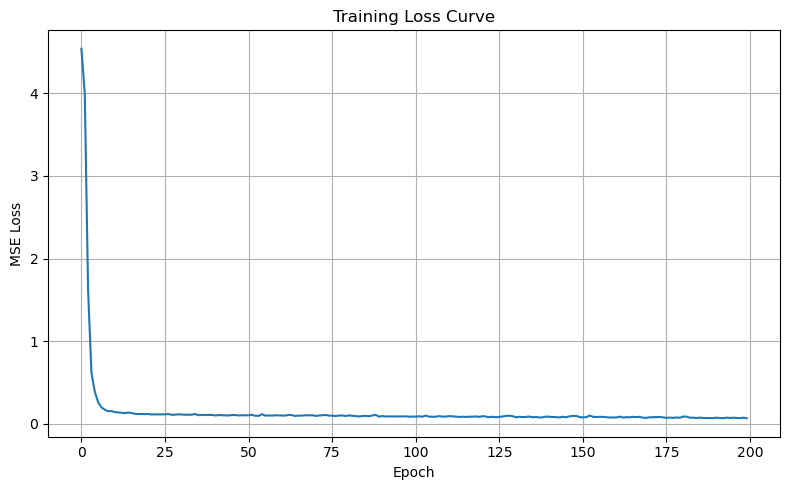

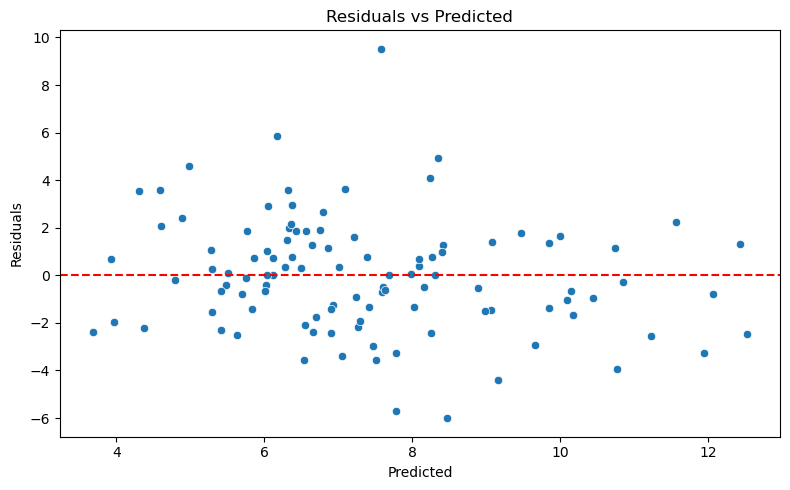

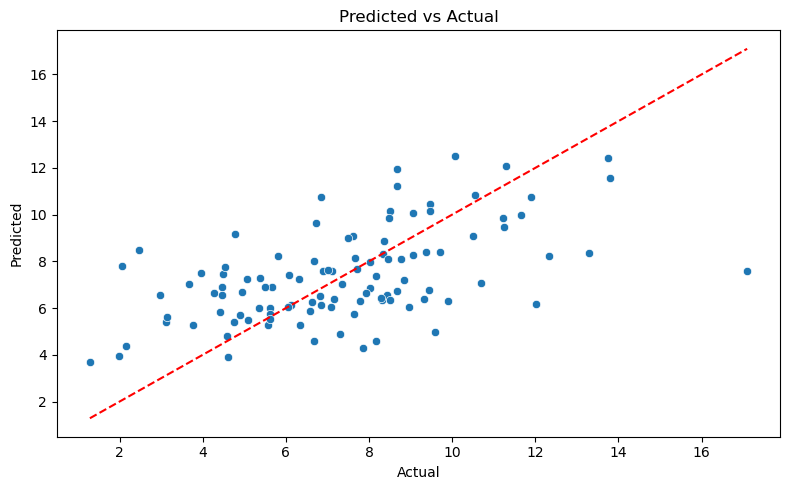

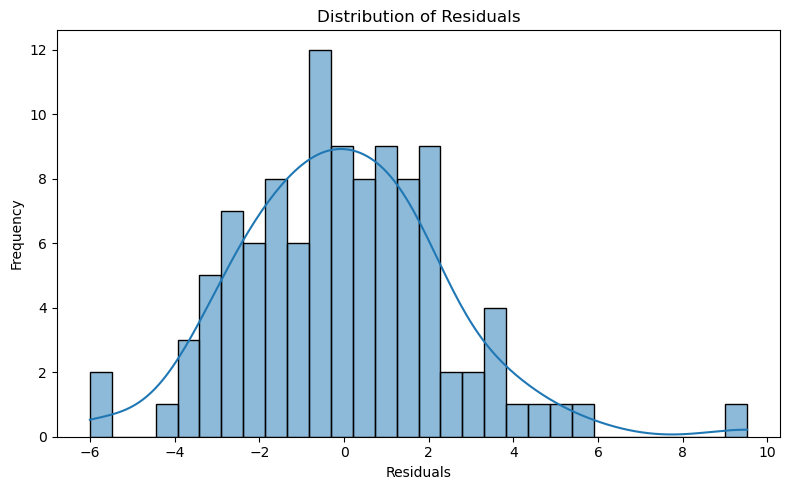

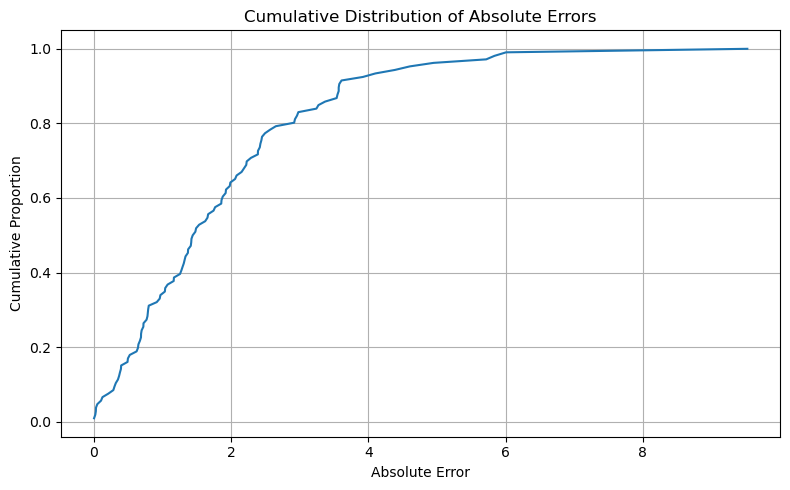

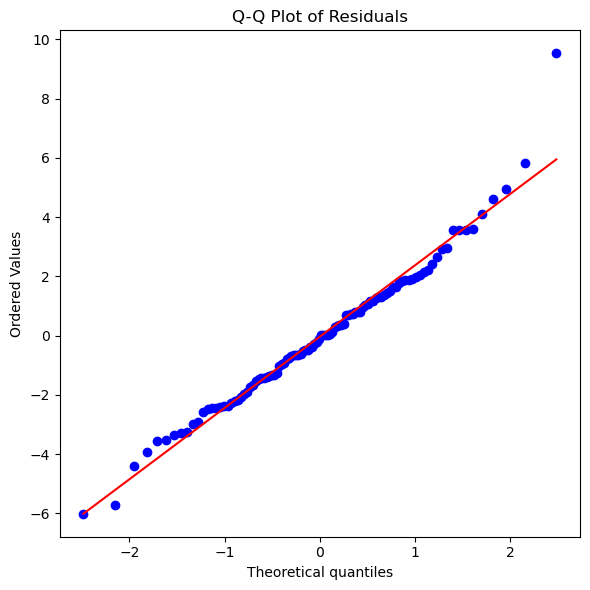

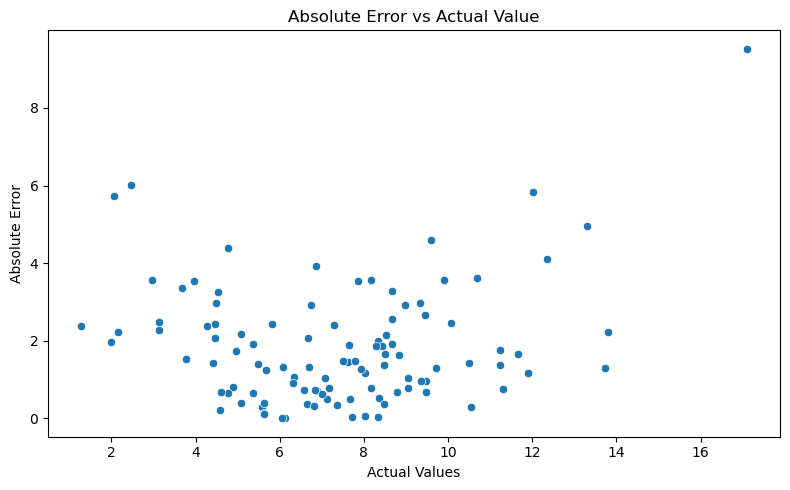


🧠 Model Architecture:
FNN(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=8, bias=True)
    (15): ReLU()
    (16): Linear(in_features=8, out_features=1, bias=True)
  )
)

💾 Best model is saved as: fnn_lr0.001_bs32_ep200_hl128x128x64x64x32x32x16x8.pt


In [51]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 64, 32), apply_log_transform=True,
                    save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"
    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y - np.min(y) + 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 10% val

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_save_path)

    return model, train_losses, X_test_tensor, y_test_tensor, X_val_tensor, y_val_tensor


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -np.inf
    best_config = None
    best_model = None
    best_train_losses = None
    best_X_test_tensor = None
    best_y_test_tensor = None

    for lr, batch_size, hidden_sizes, epochs in product(param_grid['lr'], param_grid['batch_size'], param_grid['hidden_sizes'], param_grid['epochs']):
        model, train_losses, X_test_tensor, y_test_tensor, _, _ = run_fnn_pytorch(
            csv_path, epochs, batch_size, lr, hidden_sizes, apply_log_transform=True, save_model=False)

        model.eval()
        with torch.no_grad():
            preds = model(X_test_tensor).numpy().flatten()
        true_vals = y_test_tensor.numpy().flatten()
        preds = np.expm1(preds)
        true_vals = np.expm1(true_vals)

        mse = mean_squared_error(true_vals, preds)
        r2 = r2_score(true_vals, preds)

        results.append({"lr": lr, "batch_size": batch_size, "hidden_sizes": str(hidden_sizes), "epochs": epochs, "mse": mse, "r2": r2})

        if r2 > best_r2:
            best_r2 = r2
            best_config = {"lr": lr, "batch_size": batch_size, "hidden_sizes": hidden_sizes, "epochs": epochs, "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"}
            best_model = model
            best_train_losses = train_losses
            best_X_test_tensor = X_test_tensor
            best_y_test_tensor = y_test_tensor
            if save_best_model:
                torch.save(model.state_dict(), best_config["model_name"])

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    return best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor




# Data Source   
window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")


# Define the hyperparameter search space
param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN grid search...")

    # Run grid search
    best_model, best_config, results_df, best_train_losses, best_X_test_tensor, best_y_test_tensor = grid_search_fnn(
        csv_path=csv_path,
        param_grid=param_grid,
        save_best_model=True,
        output_results_csv="grid_search_results.csv"
    )

    # Evaluate on test data only
    mse, r2, y_true, y_pred = evaluate_model(
        best_model, best_X_test_tensor, best_y_test_tensor, apply_log_transform=True
    )

    # Print summary again
    print("\n🏆 Final Best Model Configuration (after grid search):")
    print(best_config)

    # Print detailed evaluation summary
    print("\n📊 Final Best Model Evaluation Metrics on Test Data:")
    print(f"✅ Test MSE: {mse:.4f}")
    print(f"✅ Test R²: {r2:.4f}")
    print(f"✅ Test Samples: {len(y_true)}")
    print(f"✅ Prediction Range: min={y_pred.min():.4f}, max={y_pred.max():.4f}")
    print(f"✅ Actual Range: min={y_true.min():.4f}, max={y_true.max():.4f}")
    print(f"✅ Residual Mean: {(y_true - y_pred).mean():.4f}")
    print(f"✅ Residual Std Dev: {(y_true - y_pred).std():.4f}")

    # Plot best model performance on test data
    plot_results(y_true, y_pred, train_losses=best_train_losses)

    # Print model layer details
    if best_model:
        print("\n🧠 Model Architecture:")
        print(best_model)
        print(f"\n💾 Best model is saved as: {best_config['model_name']}")
    else:
        print("❌ No best model was found.")

else:
    print("❌ CSV file not found. Check the path and try again.")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True):
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)

    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()

    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\n📊 Model Evaluation on Test Data:")
    print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Test R-squared (R²): {r2:.4f}")

    return mse, r2, y_true, y_pred


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 64, 32), apply_log_transform=True):
    df = pd.read_csv(csv_path)
    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    df.dropna(subset=features + [target], inplace=True)
    X = df[features].values.astype(np.float32)
    y = df[target].values.astype(np.float32).reshape(-1, 1)

    if apply_log_transform:
        y = np.log1p(y - y.min() + 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

    return model, train_losses, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_grid_search_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None
    best_train_losses = None
    best_X_val_tensor = None
    best_y_val_tensor = None
    best_X_test_tensor = None
    best_y_test_tensor = None

    for lr, batch_size, hidden_sizes, epochs in product(
            param_grid['lr'], param_grid['batch_size'], param_grid['hidden_sizes'], param_grid['epochs']):

        print(f"\n🔍 Testing Config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")
        model, train_losses, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = run_fnn_pytorch(
            csv_path, epochs=epochs, batch_size=batch_size, lr=lr, hidden_sizes=hidden_sizes)

        mse, r2, _, _ = evaluate_model(model, X_val_tensor, y_val_tensor, apply_log_transform=True)

        results.append({"lr": lr, "batch_size": batch_size, "hidden_sizes": str(hidden_sizes),
                        "epochs": epochs, "mse": round(mse, 4), "r2": round(r2, 4)})

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_train_losses = train_losses
            best_X_val_tensor, best_y_val_tensor = X_val_tensor, y_val_tensor
            best_X_test_tensor, best_y_test_tensor = X_test_tensor, y_test_tensor
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"
            }
            if save_best_model:
                torch.save(model.state_dict(), best_config['model_name'])
                print(f"💾 Saved best model: {best_config['model_name']}")

    pd.DataFrame(results).to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    return best_model, best_config, pd.DataFrame(results), best_train_losses, best_X_val_tensor, best_y_val_tensor, best_X_test_tensor, best_y_test_tensor





# Data Source   
window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")


# Define the hyperparameter search space
param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN grid search...")

    # Run grid search
    best_model, best_config, results_df, best_train_losses, best_X_val_tensor, best_y_val_tensor, best_X_test_tensor, best_y_test_tensor = grid_search_fnn(
        csv_path=csv_path,
        param_grid=param_grid,
        save_best_model=True,
        output_results_csv="grid_search_results.csv"
    )

    # Evaluate on test data only
    mse, r2, y_true, y_pred = evaluate_model(
        best_model, best_X_test_tensor, best_y_test_tensor, apply_log_transform=True
    )

    # Print summary again
    print("\n🏆 Final Best Model Configuration (after grid search):")
    print(best_config)

    # Print detailed evaluation summary
    print("\n📊 Final Best Model Evaluation Metrics on Test Data:")
    print(f"✅ Test MSE: {mse:.4f}")
    print(f"✅ Test R²: {r2:.4f}")
    print(f"✅ Test Samples: {len(y_true)}")
    print(f"✅ Prediction Range: min={y_pred.min():.4f}, max={y_pred.max():.4f}")
    print(f"✅ Actual Range: min={y_true.min():.4f}, max={y_true.max():.4f}")
    print(f"✅ Residual Mean: {(y_true - y_pred).mean():.4f}")
    print(f"✅ Residual Std Dev: {(y_true - y_pred).std():.4f}")

    # Plot best model performance on test data
    plot_results(y_true, y_pred, train_losses=best_train_losses)

    # Print model layer details
    if best_model:
        print("\n🧠 Model Architecture:")
        print(best_model)
        print(f"\n💾 Best model is saved as: {best_config['model_name']}")
    else:
        print("❌ No best model was found.")

else:
    print("❌ CSV file not found. Check the path and try again.")



📂 CSV file found! Running FNN grid search...

🔍 [1/16] Config: lr=0.001, batch_size=16, hidden_sizes=(128, 64, 32), epochs=100

📊 Model Evaluation on Test Data:
✅ Test Mean Squared Error (MSE): 3.3017
✅ Test R-squared (R²): 0.3915
💾 Best model saved as: fnn_lr0.001_bs16_ep100_hl128x64x32.pt

🔍 [2/16] Config: lr=0.001, batch_size=16, hidden_sizes=(128, 64, 32), epochs=200

📊 Model Evaluation on Test Data:
✅ Test Mean Squared Error (MSE): 3.0944
✅ Test R-squared (R²): 0.4297
💾 Best model saved as: fnn_lr0.001_bs16_ep200_hl128x64x32.pt

🔍 [3/16] Config: lr=0.001, batch_size=16, hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8), epochs=100

📊 Model Evaluation on Test Data:
✅ Test Mean Squared Error (MSE): 4.4479
✅ Test R-squared (R²): 0.1802

🔍 [4/16] Config: lr=0.001, batch_size=16, hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8), epochs=200

📊 Model Evaluation on Test Data:
✅ Test Mean Squared Error (MSE): 4.5769
✅ Test R-squared (R²): 0.1565

🔍 [5/16] Config: lr=0.001, batch_size=32, hidden

ValueError: not enough values to unpack (expected 8, got 6)